<a href="https://colab.research.google.com/github/romiebanerjee/laplace/blob/master/segmentation_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


In [21]:
#helper fucntions
# Preprocess the input image
def preprocess(image_path):
    input_image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    return input_batch, input_image

# Run inference
def predict(model, input_batch):
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    return output.argmax(0)  # Get predicted class for each pixel

# Visualize results
def visualize(input, output, input_name:str, output_name:str):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input)
    plt.title(input_name)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title(output_name)
    plt.axis("off")
    plt.show()

In [17]:
# Download a pretrained FCN model (ResNet50 backbone)
model = torchvision.models.segmentation.fcn_resnet50(weights='DEFAULT', num_classes = 21).to(device)

100%|██████████| 2.37M/2.37M [00:00<00:00, 7.84MB/s]


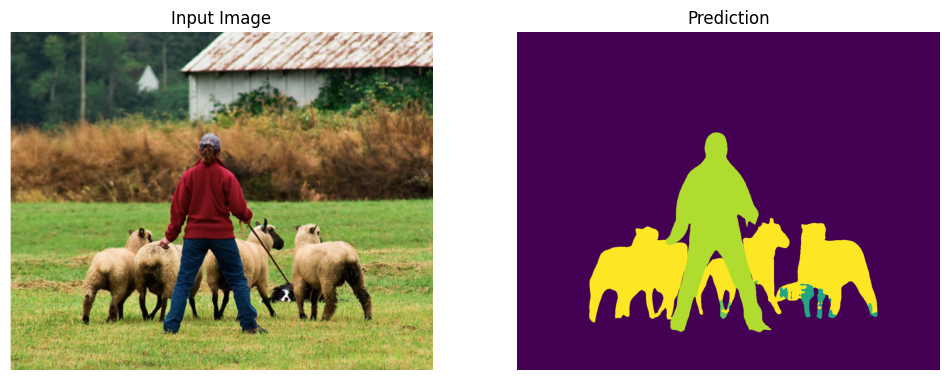

In [18]:
model.eval()
# Download example image (or replace with your own)
image_url = "https://github.com/pytorch/hub/raw/master/images/deeplab1.png"
image_path = "example_image.jpg"
torch.hub.download_url_to_file(image_url, image_path)

# Preprocess, predict, visualize
input_batch, input_image = preprocess(image_path)
prediction = predict(model, input_batch.to(device))
visualize(input_image, prediction.cpu().numpy(), "Input Image", "Prediction")

In [5]:
!git clone https://github.com/romiebanerjee/laplace.git
%cd laplace
from kfac.kfac import KFAC

Cloning into 'laplace'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 59 (delta 22), reused 45 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 389.49 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/laplace


In [6]:
mykfac = KFAC(model.to(device), device=device)

In [7]:

def random_pdsm(size, device):
    """Generate a random positive definite symmetric matrix"""
    # Empirical covariance of randomly sampled vectors
    n_samples = 100
    grads = torch.randn(n_samples, size, device = device)
    A = (grads -grads.mean(dim=0)).T @ (grads - grads.mean(dim=0))
    return A


def random_fisher(model):
  rand_fisher = dict()
  for name, module in model.named_modules():
    if module.__class__.__name__ in ['Conv2d']:
      c_out, c_in, h, w = module.weight.shape
      # print(f'out: {c_out}, in: {c_in}, h: {h}, w: {w}')
      q_size = c_in*h*w
      h_size = c_out
      Q = random_pdsm(q_size, device)
      H = random_pdsm(h_size, device)
      rand_fisher[name] =  [Q,H]
  return rand_fisher

mykfac.fisher = random_fisher(model)

In [8]:
# mykfac.kf_eigens()
# mykfac.invert_cholesky()
# mykfac.invert_fisher()

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# torch.save(mykfac.fisher, '/content/drive/MyDrive/models/fcresnet50_fisher.pt')
# torch.save(mykfac.invchol, '/content/drive/MyDrive/models/fcresnet50_invchol.pt')
# torch.save(mykfac.invfisher, '/content/drive/MyDrive/models/fcresnet50_invfisher.pt')

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# mykfac.fisher = torch.load('/content/drive/MyDrive/models/fcresnet50_fisher.pt', map_location='cpu')
mykfac.invchol = torch.load('/content/drive/MyDrive/models/fcresnet50_invchol.pt', map_location='cpu')
# mykfac.invfisher = torch.load('/content/drive/MyDrive/models/fcresnet50_invfisher.pt', map_location='cpu')

Mounted at /content/drive


In [26]:
#MC-GLM uncertainties
import matplotlib.pyplot as plt
from tqdm import tqdm

logits = mykfac.model(input_batch.to(device))['out'][0] #logits (21, h, w)

eps = 1e-12 #for numerical differentiation
mc_preds = []
iters = 8 #number of monte-carlo samples
with torch.no_grad():
    for i in tqdm(range(iters)):
        mykfac.sample_and_replace(eps = eps)
        output_logits_mc = mykfac.model(input_batch.to(device))['out'][0]
        # print(output_logits_mc)
        mc_preds.append(output_logits_mc)

mc_output_stacked = torch.stack(mc_preds) # shape: (iters, 21, h, w)

A = (mc_output_stacked - logits)/eps #shape: (iters, 21, h, w)

B = torch.matmul(A.permute(2,3,1,0), A.permute(2,3,0,1)) #shape: (h, w, n_classes, n_classes)
final = torch.sum(torch.diagonal(B, dim1=-2, dim2=-1), dim = -1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 8/8 [01:14<00:00,  9.37s/it]


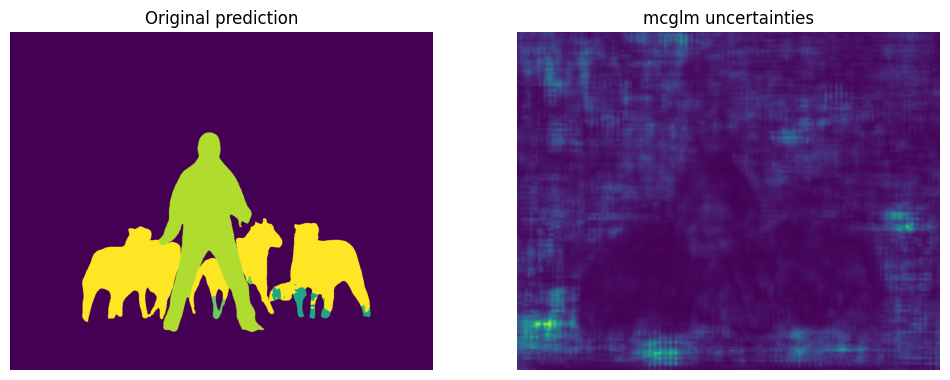

In [25]:
visualize(logits.argmax(dim=0).detach().numpy(), final.detach().numpy(), "Original prediction", "mcglm uncertainties")